https://www.kaggle.com/code/kanncaa1/recurrent-neural-network-with-pytorch/notebook 

https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/#3-building-a-recurrent-neural-network-with-pytorch-gpu

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
from scipy import signal
import numpy as np
import build.pybind_modules.dsp_module as cu
import build.pybind_modules.matrix_module as myMatrix
from math import ceil

import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
# from utils import get_dataset_from_arrays
from torch.utils.data import DataLoader
from torch.autograd import Variable
import random
import librosa

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("input/"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# check if we speed up computation by using a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Available: ".format(torch.cuda.is_available()))
print(device)

GPU Available: 
cuda:0


#### Digit Recognizer

Testing a neural network for digit recognition for future reference

In [4]:
"""
Process and organize data from AudioMNIST dataset
"""
fs = 48000
nfft = 256
noverlap = -1
nfilt = 40
num_ceps = 13
nn_data_cols = 48
nn_data_rows = 12
# AudioMNIST_size = 30000

# ratio = 0.9
# train_set_size = int(AudioMNIST_size * ratio)
# dev_set_size = int(AudioMNIST_size * (1 - ratio))

# initialize arrays to hold processed data
l_train_set = []
l_train_labels = []
l_dev_set = []
l_dev_set_labels = []

# randomize access into audio files
random.seed(9001)
# randomized_data = random.sample(range(len(ds.audio)), len(ds.audio))
# train_indices = randomized_data[:train_set_size]
# dev_indices = randomized_data[train_set_size:]
curr_dir = os.getcwd() + '/' + 'AudioMNIST/data'

# iterate through the first 59 speakers
for i in range(59):
    # form digit for accessing speaker directory 
    digit = i + 1
    if digit < 10:
        digit = '0'+str(digit)
    else:
        digit = str(digit)
    curr_audios = os.listdir(curr_dir + '/' + digit)

    # iterate through audio files per speaker
    for audio_name in curr_audios:

        # get the label of the current wav file
        curr_label = [x for x in audio_name if x.isdigit()][0]
        """ This computes the MFCC and appends the original data """
        # downsamping from 48 khz to 8 khz
        sig, fs = librosa.load(curr_dir+'/'+digit+'/'+audio_name, sr=8000)

        curr_processed = np.array(myMatrix.MFCC_Matrix(list(sig), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)[1:,:]

        # check if dimensions do not match and create temporary array with correct dimensions
        if curr_processed.shape[1] != nn_data_cols:
            curr_augment = np.zeros((nn_data_rows, nn_data_cols), dtype=curr_processed.dtype)
            for col in range(nn_data_cols):
                # break if column is greater than the number of processed columns
                if col >= curr_processed.shape[1]:
                    break
                curr_augment[:,col] = curr_processed[:,col]
            l_train_set.append(curr_augment)
        else:
            l_train_set.append(curr_processed)
        
        l_train_labels.append(curr_label)

        
        """ 
        These check if the processed data has less time os.getcwd() + '/raw_voice_files/0_jorge/0'frames than the desired number. If so, augment the data in every possible combination
        and append their variants to the training set. This should hopefully help train the NN so that it can recognize the signficant features in 
        different time frames.
        """
        # if curr_processed.shape[1] < nn_data_cols:
        #     num_augments = nn_data_cols - curr_processed.shape[1]
        #     for n in range(num_augments):
        #         curr_augment = np.zeros((nn_data_rows, nn_data_cols),dtype=curr_processed.dtype)
        #         for col in range(curr_processed.shape[1]):
        #             curr_augment[:,n + col] = curr_processed[:,col]
        #         l_train_set.append(curr_augment)
        #         l_train_labels.append(curr_label)
        # else:
        #     l_train_set.append(curr_processed)
        #     l_train_labels.append(curr_label)
        

for i in range(1):
    digit = i + 59 + 1
    if digit < 10:
        digit = '0'+str(digit)
    else:
        digit = str(digit)
    curr_audios = os.listdir(curr_dir + '/' + digit)
    for audio_name in curr_audios:
        l_dev_set_labels.append([x for x in audio_name if x.isdigit()][0])
        sig, fs = librosa.load(curr_dir+'/'+digit+'/'+audio_name, sr=8000)
        curr_processed = np.array(myMatrix.MFCC_Matrix(list(sig), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)[1:,:]
        if curr_processed.shape[1] != nn_data_cols:
            curr_augment = np.zeros((nn_data_rows, nn_data_cols), dtype=curr_processed.dtype)
            for col in range(nn_data_cols):
                # break if column is greater than the number of processed columns
                if col >= curr_processed.shape[1]:
                    break
                curr_augment[:,col] = curr_processed[:,col]
            l_dev_set.append(curr_augment)
        else:
            l_dev_set.append(curr_processed)


In [5]:
# processing and using data from trimmed_voice_files
"""
Process and organize data from trimmed_voice_files
"""
fs = 48000
nfft = 256
noverlap = -1
nfilt = 40
num_ceps = 13
nn_data_cols = 48
nn_data_rows = 12

# initialize arrays to hold processed data
# l_train_set = []
# l_train_labels = []
# l_dev_set = []
# l_dev_set_labels = []

curr_dir = os.getcwd() + '/' + 'trimmed_voice_files'
curr_audios = os.listdir(curr_dir)
curr_audios.sort()

parent_read_dir = os.getcwd() + '/trimmed_voice_files'

raw_file_speakers = os.listdir(parent_read_dir)

for speaker in raw_file_speakers:
    speaker_read_dir = parent_read_dir + '/' + speaker
    digit_dir = os.listdir(speaker_read_dir)

    for digit in digit_dir:
        curr_label = [x for x in digit if x.isdigit()][0]

        digit_read_dir = speaker_read_dir + '/' + digit

        raw_file_names = os.listdir(digit_read_dir)

        for n in range(len(raw_file_names)):
            audio_name = raw_file_names[n]
            curr_label = [x for x in audio_name if x.isdigit()][0]
            """ This computes the MFCC and appends the original data """
            sig, fs = librosa.load(digit_read_dir + '/' + audio_name, sr=8000)
            curr_processed = np.array(myMatrix.MFCC_Matrix(list(sig), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)[1:,:]
            """ 
            These check if the processed data has less time frames than the desired number. If so, augment the data in every possible combination
            and append their variants to the training set. This should hopefully help train the NN so that it can recognize the signficant features in 
            different time frames.
            """
            curr_augment = np.zeros((nn_data_rows, nn_data_cols), dtype=curr_processed.dtype)
            for i in range(curr_processed.shape[1]):
                if i == nn_data_cols:
                    break
                curr_augment[:, i] = curr_processed[:, i]
            n_mod = n % 60
            if n_mod < 50:
                l_train_set.append(curr_augment)
                l_train_labels.append(curr_label)
            else:
                l_dev_set.append(curr_augment)
                l_dev_set_labels.append(curr_label)


    

l_train_labels = np.array(l_train_labels, dtype=np.int64)
l_dev_set_labels = np.array(l_dev_set_labels, dtype=np.int64)


In [6]:
train_set = np.zeros((len(l_train_set),nn_data_rows*nn_data_cols),dtype=np.float64)
dev_set = np.zeros((len(l_dev_set),nn_data_rows*nn_data_cols), dtype=np.float64)
for i in range(len(l_train_set)):
    train_set[i] = l_train_set[i].ravel()

for i in range(len(l_dev_set)):
    dev_set[i] = l_dev_set[i].ravel()

In [7]:
print(len(l_train_set))
print(len(l_dev_set))
print(len(l_train_labels))
print(len(l_dev_set_labels))

30510
700
30510
700


(30510,)
[4 8 1 3 9 5 4 9 9 8 9 8 5 3 5 7 5 3 2 3 6 4 6 1 4 6 6 1 7 7 3 2 1 1 6 3 8
 2 5 7 8 8 4 3 0 8 9 2 0 6 9 3 3 6 1 6 0 6 1 8 1 2 9 7 6 2 0 1 7 9 0 6 5 8
 9 4 0 6 3 9 1 6 2 1 1 4 5 7 9 3 0 8 6 7 2 6 2 4 5 1 8 3 0 1 6 5 9 3 8 5 0
 8 9 8 5 0 6 0 5 1 4 7 8 3 3 4 0 2 1 7 7 1 4 5 6 2 1 0 2 6 2 0 7 6 2 8 8 8
 8 4 5 1 1 0 4 0 2 0 3 0 4 0 3 9 8 6 9 5 5 4 2 4 0 6 5 8 6 2 2 8 4 5 2 4 1
 2 5 9 6 5 7 0 1 0 9 0 6 7 2 1 2 2 8 4 6 6 6 4 4 8 9 5 9 5 5 8 1 6 3 3 0 5
 9 1 9 2 2 4 2 7 1 0 0 9 0 0 3 3 6 7 4 3 6 9 5 4 5 0 8 7 2 7 2 0 4 3 9 5 2
 0 0 7 0 5 4 2 0 6 2 2 6 6 3 3 8 6 9 1 5 8 7 5 7 6 6 7 7 4 7 4 8 7 7 6 5 3
 1 2 8 0 8 9 2 3 2 8 6 2 7 3 1 2 1 4 7 8 4 3 2 6 8 0 4 3 2 7 9 8 8 4 9 3 3
 3 9 9 3 4 1 1 8 8 8 3 1 1 7 2 1 2 5 1 0 6 5 8 5 1 3 3 5 0 7 1 4 1 3 2 9 5
 3 3 6 5 7 7 2 9 0 9 8 8 1 5 7 5 5 5 0 9 6 2 4 5 8 4 9 7 0 5 6 3 0 7 6 7 0
 3 0 9 2 4 3 3 2 4 3 6 6 8 0 9 4 1 9 7 8 7 2 1 7 4 0 2 4 6 9 8 9 8 9 2 3 4
 8 4 8 3 6 7 5 4 4 0 9 9 4 5 9 7 4 7 5 5 1 1 4 1 9 7 1 9 5 1 9 7 7 2 9 9 4
 3 7 1 7 7 0 3 6

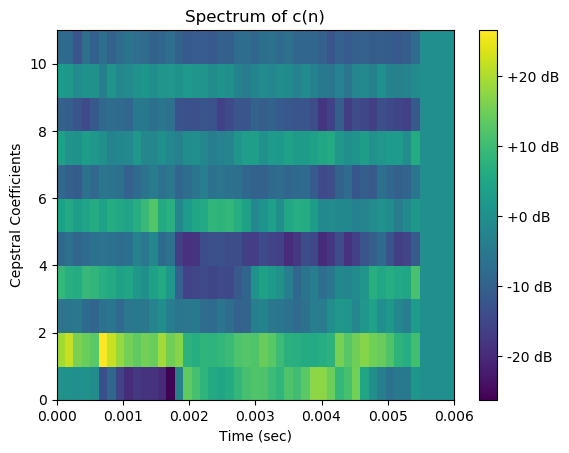

In [8]:
"""
Run this block to check some of the outputs from the block above
"""
check_output = True
if check_output:
    print(l_train_labels.shape)
    print(l_dev_set_labels)
    print(train_set[80])

    t_time = nn_data_cols / fs
    data = np.resize(train_set[80],(nn_data_rows, nn_data_cols))
    t = np.linspace(0, t_time, nn_data_cols)
    n = np.arange(nn_data_rows)
    plt.title("Spectrum of c(n)")
    plt.ylabel("Cepstral Coefficients")
    plt.xlabel("Time (sec)")
    plt.pcolormesh(t, n, data)
    plt.colorbar(format="%+2.f dB")

In [9]:
def compute_accuracies(predicted_labels, dev_set, dev_labels):
    yhats = predicted_labels
    # np.int was deprecated in latest versions
    # assert predicted_labels.dtype == np.int, "Your predicted labels have type {}, but they should have type np.int (consider using .astype(int) on your output)".format(predicted_labels.dtype)
    assert predicted_labels.dtype == int, "Your predicted labels have type {}, but they should have type np.int (consider using .astype(int) on your output)".format(predicted_labels.dtype)

    if len(yhats) != len(dev_labels):
        print("Lengths of predicted labels don't match length of actual labels", len(yhats), len(dev_labels))
        return 0., 0., 0., 0.
    accuracy = np.mean(yhats == dev_labels)
    conf_m = np.zeros((len(np.unique(dev_labels)),len(np.unique(dev_labels))))
    for i,j in zip(dev_labels,predicted_labels):
        conf_m[i,j] +=1

    return accuracy, conf_m

def get_parameter_counts(net):
    """ Get the parameters of your network
    @return params: a list of tensors containing all parameters of the network
            num_params: count of the total number of parameters
    """
    params = net.parameters()
    num_parameters = sum([ np.prod(w.shape) for w  in params])

    return num_parameters,params

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X,y):
        """
        Args:
            X [np.array]: features vector
            y [np.array]: labels vector          
        """
        self.data = X
        self.labels = y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        features = self.data[idx,:]
        label = self.labels[idx]
        sample = {'features': features,'labels': label}
        return sample

class NeuralNet(nn.Module):
    def __init__(self, lrate, in_size, out_size, mfcc_dim, loss_fn=nn.CrossEntropyLoss(), weight_decay=0.01):
        """
        Initializes the layers of your neural network.

        @param lrate: learning rate for the model
        @param loss_fn: A loss function defined as follows:
            @param yhat - an (N,out_size) Tensor
            @param y - an (N,) Tensor
            @return l(x,y) an () Tensor that is the mean loss
        @param in_size: input dimension
        @param out_size: output dimension

        For Part 1 the network should have the following architecture (in terms of hidden units):

        in_size -> h ->  out_size , where  1 <= h <= 256
        
        We recommend setting lrate to 0.01 for part 1.

        """
        super(NeuralNet, self).__init__()
        # define layers for music classification 
        self.mfcc_dim = mfcc_dim

        kernel_size = (3,3)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=kernel_size, stride=1, padding=1, device=device)
        self.maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=kernel_size, stride=1, padding=1, device=device)
        self.dropout_1 = nn.Dropout(p=0.1)
        self.dropout_2 = nn.Dropout(p=0.16)
        self.dropout_3 = nn.Dropout(p=0.12)
        self.relu = nn.ReLU()

        self.model = nn.Sequential(self.conv1, nn.ReLU6(), self.maxpool, self.conv2, nn.ReLU6(), self.maxpool, self.dropout_1)


        self.linear_1 = nn.Linear(in_features=20*mfcc_dim[0]*mfcc_dim[1], out_features=5000)
        self.linear_2 = nn.Linear(in_features=5000, out_features=1000)
        self.linear_3 = nn.Linear(in_features=1000, out_features=out_size)

        # self.model_2 = nn.Sequential(self.linear_1, self.dropout_2, self.linear_2, self.dropout_3, self.linear_3)

        self.loss_fn = loss_fn
        self.double()

        self.optimizer = optim.SGD(self.parameters(), lr=lrate, weight_decay=weight_decay)

    def conv_out_size(self, inp_size, kernel_size, dilation, padding, stride):
        return ((inp_size + 2*padding - dilation * (kernel_size - 1) - 1) // stride) + 1
    

    def forward(self, x):
        """Performs a forward pass through your neural net (evaluates f(x)).

        @param x: an (N, in_size) Tensor
        @return y: an (N, out_size) Tensor of output from the network
        """
        x = x.view(x.shape[0], 1, self.mfcc_dim[0], self.mfcc_dim[1])
        x = self.model(x)
        x = x.view(x.shape[0], 20*self.mfcc_dim[0]*self.mfcc_dim[1])
        # x = self.model_2(x)
        # print("shape x before l1: {}".format(x.shape))
        x = self.linear_1(x)
        x = self.dropout_2(x)
        # print("shape x before l2: {}".format(x.shape))
        x = self.linear_2(x)
        x = self.dropout_3(x)
        # print("shape x before l3: {}".format(x.shape))
        x = self.linear_3(x)

        return x

    def step(self, x,y):
        """
        Performs one gradient step through a batch of data x with labels y.

        @param x: an (N, in_size) Tensor
        @param y: an (N,) Tensor
        @return L: total empirical risk (mean of losses) for this batch as a float (scalar)
        """
        # raise NotImplementedError("You need to write this part!")
        x = x.to(device)
        y = y.to(device)

        # zero out the optimizer
        self.optimizer.zero_grad()

        # pass the batch through the model
        y_hat = self.forward(x)
        # compute the lost
        loss = self.loss_fn(y_hat, y)

        # update model
        loss.backward()
        self.optimizer.step()
        return loss.cpu().item()
        return loss.item()
        return loss.detach().cpu().numpy()



def fit(in_size, out_size,train_set,train_labels,dev_set,epochs,batch_size=100, lrate=1e-6, weight_decay=0.01):
    """ Make NeuralNet object 'net' and use net.step() to train a neural net
    and net(x) to evaluate the neural net.

    @param train_set: an (N, in_size) Tensor
    @param train_labels: an (N,) Tensor
    @param dev_set: an (M,) Tensor
    @param epochs: an int, the number of epochs of training
    @param batch_size: size of each batch to train on. (default 100)

    This method _must_ work for arbitrary M and N.

    The model's performance could be sensitive to the choice of learning rate.
    We recommend trying different values in case your first choice does not seem to work well.

    @return losses: list of floats containing the total loss at the beginning and after each epoch.
            Ensure that len(losses) == epochs.
    @return yhats: an (M,) NumPy array of binary labels for dev_set
    @return net: a NeuralNet object
    """
    # raise NotImplementedError("You need to write this part!")
    # print(len(train_labels))
    # print(train_set)
    # print(train_labels)
    # print(dev_set)
    
    u = train_set.mean()
    a = train_set.std()

    norm_set = (train_set-u)/a
    norm_dev = (dev_set-u)/a
    # data = MyDataset(norm_set, train_labels)
    data = MyDataset(train_set, train_labels)
    data = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=False)

    # lrate, in_size, out_size, mfcc_dim, loss_fn=nn.CrossEntropyLoss()
    NetObject = NeuralNet(lrate, in_size, out_size, mfcc_dim=(12,48), loss_fn=nn.CrossEntropyLoss(), weight_decay=weight_decay)
    NetObject.to(device)

    losses = []
    for epoch in range(epochs):
        print("\rEpoch {}".format(epoch), end="")
        epoch_loss = 0.0
        for batch in data:
            batch_x, batch_y = batch
            # print("batch x size: {}".format(batch[batch_x].dtype))
            # print("batch y size: {}".format(batch[batch_y].dtype))
            epoch_loss += NetObject.step(batch[batch_x], batch[batch_y])
        epoch_loss /= len(data)

        losses.append(epoch_loss)

    ytemp = np.zeros((len(dev_set), out_size))
    with torch.no_grad():
        # ytemp = NetObject.forward(norm_dev).detach().cpu().numpy()
        ytemp = NetObject.forward(dev_set.to(device)).detach().cpu().numpy()
        # for i in range(len(dev_set)):
        #     # dev = dev_set[i]
        #     dev = norm_dev[i]
        #     dev = Variable(dev.view(-1, seq_dim, in_size)).requires_grad_().to(device)
        #     ret_val = NetObject.forward(dev).detach().numpy()
        #     # print(ret_val)
        #     ytemp[i] = ret_val
        
    # print(ytemp)
    
    predicted_labels = []
    for i in range(len(ytemp)):
        idx = np.argmax(ytemp[i]).astype(int)
        predicted_labels.append(idx)

    predicted_labels = np.array(predicted_labels)
        
    return losses,predicted_labels,NetObject

In [10]:
batch_size = 64
epochs = 20
input_dim = 12 # num ceps - 1
output_dim = 10 # number of genres
weight_decay = 1e-2
learning_rate = 1e-2

# convert numpys to torches
print("shape of train_set: {}".format(train_set.shape))
train_set = torch.tensor(train_set, dtype=torch.float64)
l_train_labels = torch.tensor(l_train_labels, dtype=torch.int64)
dev_set = torch.tensor(dev_set, dtype=torch.float64)
# dev_set_labels = torch.tensor(dev_set_labels)

shape of train_set: (30510, 576)


In [12]:

L, predicted_labels, net = fit(input_dim, output_dim, train_set,l_train_labels,dev_set,epochs,batch_size,lrate=learning_rate, weight_decay=weight_decay)

assert type(predicted_labels) == np.ndarray, "your fit function returned the predicted labels as {} instead of np.ndarray. Make sure to use .detach().cpu().numpy() on the network output - and don't forget to argmax it!".format(type(predicted_labels))
assert type(L) == list,"your fit function returned the losses as {} instead of list. Make sure you are returning a list of losses (with length equal to the number of epochs)".format(type(L))

accuracy, conf_m = compute_accuracies(predicted_labels, dev_set, l_dev_set_labels)

Epoch 0

KeyboardInterrupt: 

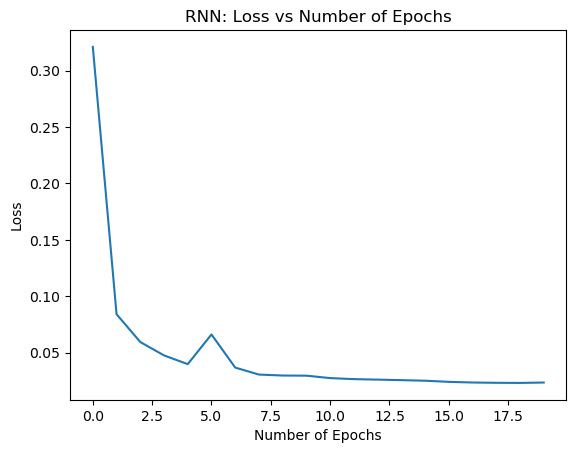

In [ ]:
iterations = [i for i in range(epochs)]
plt.plot(iterations, L)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of Epochs")
plt.show()

In [ ]:
print("\n Accuracy:", accuracy)
print("\nConfusion Matrix = \n {}".format(conf_m))
num_parameters,params = get_parameter_counts(net)
print('\nparameters = {} \n'.format(num_parameters))


 Accuracy: 0.9228571428571428

Confusion Matrix = 
 [[68.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
 [ 0. 67.  0.  0.  0.  0.  0.  0.  0.  3.]
 [ 0.  0. 69.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 70.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 70.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 70.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 68.  0.  1.  1.]
 [ 3.  0.  0. 42.  0.  0.  0. 25.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 70.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0. 69.]]

parameters = 62617930 



In [ ]:
# saving a model
# torch.save(net.state_dict(),'4_5_demo_run.pth')

In [ ]:
# loading the pytorch model
net = NeuralNet(learning_rate, input_dim, output_dim, mfcc_dim=(12,48), loss_fn=nn.CrossEntropyLoss(), weight_decay=weight_decay)
net.load_state_dict(torch.load('4_5_demo_run.pth'))
net.to(device) # sends neural network to the gpu
net.eval()

NeuralNet(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=1, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout_1): Dropout(p=0.1, inplace=False)
  (dropout_2): Dropout(p=0.16, inplace=False)
  (dropout_3): Dropout(p=0.12, inplace=False)
  (relu): ReLU()
  (model): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU6()
    (2): MaxPool2d(kernel_size=(3, 3), stride=1, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU6()
    (5): MaxPool2d(kernel_size=(3, 3), stride=1, padding=1, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.1, inplace=False)
  )
  (linear_1): Linear(in_features=11520, out_features=5000, bias=True)
  (linear_2): Linear(in_features=5000, out_features=1000, bias=True)
  (linear_3): Linear(in

In [ ]:
FRAME_SIZE = 1024
# 100e4 for AudioMNIST data set
# for android tablet
THRESHOLD = 200e6 # must be tuned
FRAME_SETBACK = 10 # number of frames to prepend before first frame with significant energy content above the threshold

NUM_ROWS = int((1024 / 2) + 1)
NUM_COLS = 48 # total number of frames to leave in trimmed audio data

In [ ]:
def ece420ProcessFrame(frame, threshold = THRESHOLD):
    isVoiced = 0

    #### YOUR CODE HERE ####
    sum = 0
    for n in range(len(frame)):
        sum += abs(frame[n])**2

    if sum > threshold:
        isVoiced = 1

    # print("sum: {}".format(sum))
    return isVoiced

In [ ]:
# song_path = "AudioMNIST/data/60/3_60_8.wav"
song_dir = 'dev_set_android_files/'
song_path = "2023_03_24_19_04_28.wav"
# pitch detection 
Fs, data = wavfile.read(song_dir + song_path)
num_samples = len(data)
# print("len of data: {}".format(num_samples))

noverlap = int(FRAME_SIZE / 2)
step = FRAME_SIZE - noverlap
numFrames = ceil(num_samples / step)
while ((numFrames - 1)*step + (FRAME_SIZE - 1) >= num_samples):
    numFrames -= 1

framesVoiced = np.zeros(numFrames)
# t = np.linspace(0, len(data)/Fs, numFrames)

for i in range(numFrames):
    frame = data[i * step : (i + 1) * step]
    framesVoiced[i] = ece420ProcessFrame(frame.astype(float))

first_frame = np.argwhere(framesVoiced > 0)[0,0]

first_frame = first_frame - FRAME_SETBACK if (first_frame - FRAME_SETBACK) > 0 else 0
last_frame = first_frame + NUM_COLS
print("first_frame: {}, last_frame: {}".format(first_frame, last_frame))

# altering the data
segmented_data = data[first_frame*step:last_frame*step]
wavfile.write(song_dir + song_path, rate = Fs, data=segmented_data.astype(np.int16))
# reload trimed file
y, s = librosa.load(song_dir + song_path, sr=8000)
print(len(y))
print(s)
fs, music_stereo = wavfile.read(song_dir + song_path) # Import the sound file
print(len(music_stereo))
print(fs)
fs = s
music_stereo = y
# Audio(music_stereo, rate=fs)
Audio(y, rate=s)

first_frame: 0, last_frame: 48
4096
8000
24576
48000


In [ ]:
noverlap = -1
print("fs: {}, nfft: {}, noverlap: {}, window: {}, b: {}, nfilt: {}, num_ceps: {}".format(fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps))

fs: 8000, nfft: 256, noverlap: -1, window: 2, b: 0.6, nfilt: 40, num_ceps: 13


In [ ]:
ceps = np.array(myMatrix.MFCC_Matrix(list(music_stereo), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)
ceps = ceps[1:,:]
processed_wav = ceps
# fix dimensions if necessary
print("Original Ceps Dimensions: {}".format(ceps.shape))

test_file = np.zeros((1, nn_data_cols*nn_data_rows), dtype = processed_wav.dtype)
trimmed_file = np.zeros((nn_data_rows, nn_data_cols), dtype = processed_wav.dtype)
for i in range(processed_wav.shape[1]):
     if i == nn_data_cols:
          break
     trimmed_file[:,i] = processed_wav[:, i]
test_file[0] = trimmed_file.ravel()

test_file = torch.tensor(test_file, dtype=torch.float64)
# check prediction
u = train_set.mean()
a = train_set.std()
test_file = (test_file-u)/a
result = net.forward(test_file.to(device)).detach().cpu().numpy()[0]
print(result)
first_place = np.argmax(result).astype(int)
print("1st: {}".format(first_place))
result[first_place] = -10

second_place = np.argmax(result).astype(int)
print("2nd: {}".format(second_place))
result[second_place] = -10

third_place = np.argmax(result).astype(int)
print("3rd: {}".format(third_place))

Original Ceps Dimensions: (12, 31)
[ 0.70540466 -0.2780727   0.68047738  0.56022401 -0.91418803 -1.03705966
  0.14042373  0.01774401  0.26136964 -0.14589301]
1st: 0
2nd: 2
3rd: 3


The array above shows a list of probabilites/confidence for each label, where each index of the array corresponds to its digit. We then display the top 3 results and this is how we also plan to show the results on the Android tablet as well. To maintain a reasonable scope and difficulty, our goal is to have the correct digit be in the top 3 list consistently. Below is a visual output of the sound file that was fed to the neural network. 

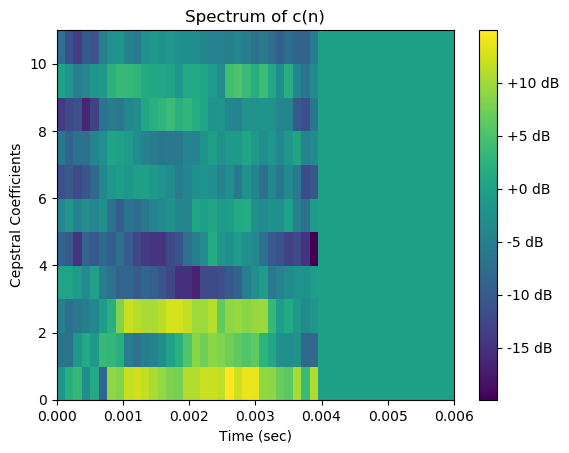

In [ ]:
t_time = nn_data_cols / fs
t = np.linspace(0, t_time, nn_data_cols)
n = np.arange(nn_data_rows)
plt.title("Spectrum of c(n)")
plt.ylabel("Cepstral Coefficients")
plt.xlabel("Time (sec)")
plt.pcolormesh(t, n, trimmed_file)
plt.colorbar(format="%+2.f dB")